In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
%matplotlib qt

In [3]:
from PIL import Image
import os
from io import BytesIO
from keras.preprocessing import image
import cv2
import hashlib

Using TensorFlow backend.


In [4]:
def image_generator(images_dir, target_size=None):
    count = 0
    while True:
        print("Data round %s" % count)
        for filename in os.listdir(images_dir):
            img = Image.open("%s/%s" % (images_dir, filename))
            if target_size is not None:
                img = img.resize(target_size)
#             img = image.load_img('%s/%s' % (images_dir, filename), target_size=target_size)

            f = BytesIO()
            img.save(f, format='JPEG', quality=100)
            bytes_content = f.getvalue()
            origin_file_size = len(bytes_content)
            yield img, origin_file_size
        count += 1
        
def simple_image_generator(images_dir):
    count = 0
    while True:
        print("Data round %s" % count)
        for filename in os.listdir(images_dir):
            img = Image.open("%s/%s" % (images_dir, filename))
            yield img
        count += 1

In [5]:
def split_88(image_data):
    blocks = []
    image_size = image_data.shape[0]
    for i in range(int(image_size / 8)):
        row = image_data[8*i:8*(i+1), :]
        for j in range(int(image_size / 8)):
            col = row[:, 8*j:8*(j+1)]
            blocks.append(col.astype(float32))
    return array(blocks)

def merge_88(blocks):
    block_count = blocks.shape[0]
    edge_len = int(sqrt(block_count))
    img_size = 8*edge_len
    image_rows = []
    for i in range(edge_len):
        img_row = hstack(blocks[edge_len*i: edge_len*(i+1), ...])
        image_rows.append(img_row)
    return vstack(image_rows)

def split_1616(image_data):
    blocks = []
    image_size = image_data.shape[0]
    for i in range(int(image_size / 16)):
        row = image_data[16*i:16*(i+1), :]
        for j in range(int(image_size / 16)):
            col = row[:, 16*j:16*(j+1)]
            blocks.append(col.astype(float32))
    return array(blocks)

def merge_1616(blocks):
    block_count = blocks.shape[0]
    edge_len = int(sqrt(block_count))
    img_size = 16*edge_len
    image_rows = []
    for i in range(edge_len):
        img_row = hstack(blocks[edge_len*i: edge_len*(i+1), ...])
        image_rows.append(img_row)
    return vstack(image_rows)

def zig_zag_flatten(a):
    return np.concatenate([np.diagonal(a[::-1,:], i)[::(2*(i % 2)-1)] for i in range(1-a.shape[0], a.shape[0])])    

In [6]:
generator = simple_image_generator('/home/hsli/imagenet-data/train/n03085013')

In [7]:
# Generate testing image
for i in range(6):
    origin_image= next(generator)

Data round 0


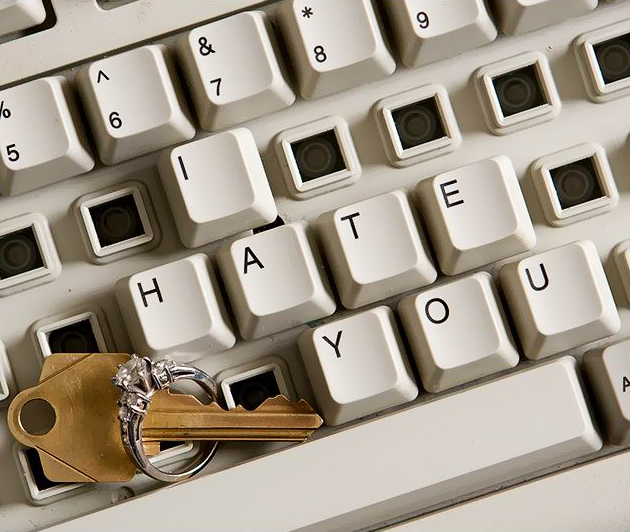

In [8]:
origin_image

# DeepN-JPEG

In [10]:
img_yuv = origin_image.convert('YCbCr')

In [11]:
channels = img_yuv.split()

In [12]:
rec_channels = []
q_tables = []
for channel in channels:
    # split and shift
    blocks = split_88(asarray(channel)) - 128
    # dct and get std_matrix
    dct_blocks = array([cv2.dct(item) for item in blocks])
    std_matrix = zeros([8, 8])
    for i in range(8):
        for j in range(8):
            std_matrix[i, j] = std(dct_blocks[:,i,j], ddof=1)

    # Build Q-table
    q_table = zeros([8, 8], dtype=int64)
    a = 255
    b = 80
    c = 240
    T1 = 20
    T2 = 60
    k1 = 9.75
    k2 = 1
    k3 = 3
    Qmin = 5
    for i in range(8):
        for j in range(8):
            std_value = std_matrix[i, j]
            if std_value <= T1:
                q = a - k1 * std_value
            elif std_value > T2:
                q = c - k3 * std_value
            else:
                q = b - k2 * std_value
            q = (q if (q > Qmin) else Qmin)
            q_table[i, j] = q
    
    q_tables.append(q_table)

    # quantization by q-table and recovery from q-table
    quantizd_dct_blocks = np.round(array([block / q_table for block in dct_blocks]))
    rec_dct_blocks = array([block * q_table for block in quantizd_dct_blocks])
    # idct, round and shift
    idct_rec_blocks = np.round(array([cv2.idct(block) for block in rec_dct_blocks])) + 128
    # merge into an image
    rec_channel = merge_88(idct_rec_blocks)
    
    rec_channels.append(clip(rec_channel, 0, 255))

rec_channels = array(rec_channels, dtype=uint8)


In [13]:
pil_channels = [Image.fromarray(channel) for channel in rec_channels]

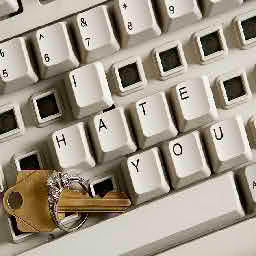

In [14]:
rec_pil_image = Image.merge("YCbCr", pil_channels).convert('RGB')
rec_pil_image

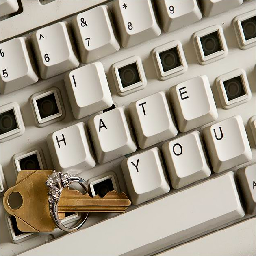

In [15]:
Image.merge("YCbCr", channels).convert('RGB')

## JPEG manual Q-table test

In [16]:
pil_qtables = {}
for idx, q_table in enumerate(q_tables):
    pil_qtables[idx] = zig_zag_flatten(q_table).tolist()

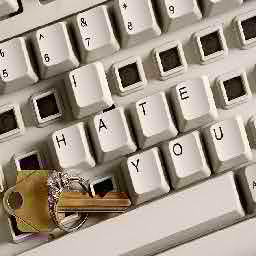

In [17]:
_origin_image = origin_image

f = BytesIO()
_origin_image.save(f, format='JPEG', subsampling=2, qtables=pil_qtables)
deepn_file_size = len(f.getvalue())
f.seek(0)
_origin_image_read = Image.open(f)
_origin_image_read

In [18]:
deepn_file_size

11230

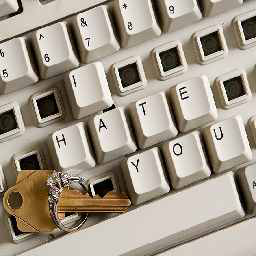

In [19]:
f = BytesIO()
origin_image.save(f, format='JPEG', subsampling=2, quality=42)
conventional_file_size = len(f.getvalue())
f.seek(0)
origin_image_read = Image.open(f)
origin_image_read

In [20]:
conventional_file_size

11120

## Model prediction test

In [21]:
from keras.applications import VGG16
from keras.applications.imagenet_utils import preprocess_input
model = VGG16()

In [22]:
image_data = asarray(origin_image_read.resize((224, 224)))
image_data = preprocess_input(image_data)

In [23]:
argmax(model.predict(expand_dims(image_data, axis=0)))

508

# View ground-truth Q-table

## Origin JPEG saving

In [9]:
f1 = BytesIO()
origin_image.save(f1, format='JPEG', quality=50)

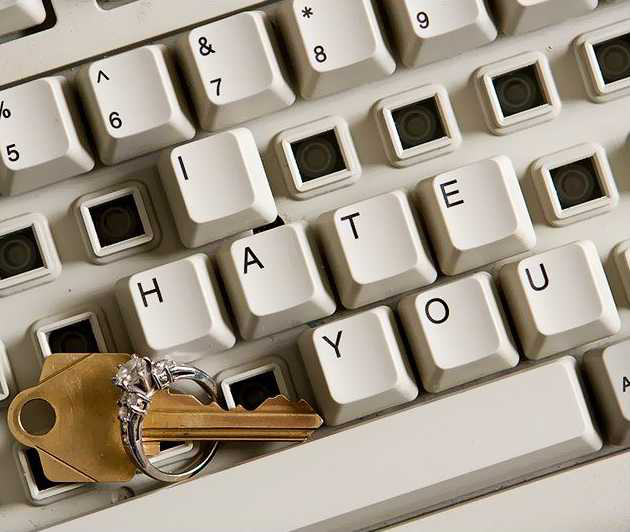

In [10]:
m1 = Image.open(f1)
m1

## Manual q-table JPEG saving

In [11]:
f2 = BytesIO()
man_qtables = {0: [16, 11, 12, 14, 12, 10, 16, 14, 13, 14, 18, 17, 16, 19, 24, 40, 26, 24, 22, 22, 24, 49, 35, 37, 29, 40, 58, 51, 61, 60, 57, 51, 56, 55, 64, 72, 92, 78, 64, 68, 87, 69, 55, 56, 80, 109, 81, 87, 95, 98, 103, 104, 103, 62, 77, 113, 121, 112, 100, 120, 92, 101, 103, 99],
               1: [17, 18, 18, 24, 21, 24, 47, 26, 26, 47, 99, 66, 56, 66, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99],
#                2: [17, 18, 18, 24, 21, 24, 47, 26, 26, 47, 99, 66, 56, 66, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99]
              }

origin_image.save(f2, format='JPEG', qtables=man_qtables)

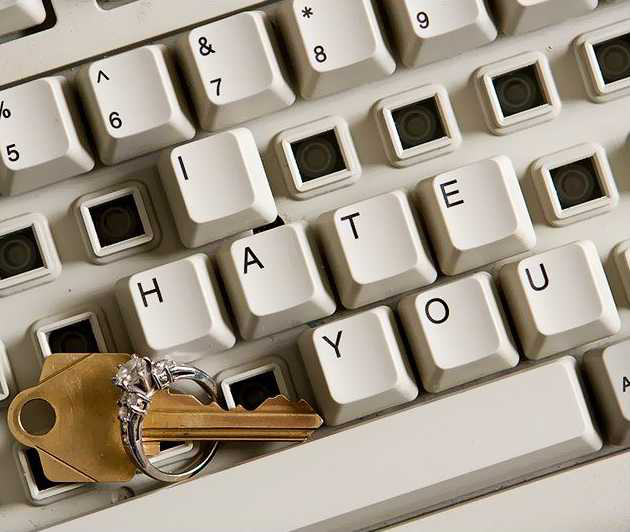

In [12]:
m2 = Image.open(f2)
m2

## Compare

In [13]:
print("Origin size: %s" % len(f1.getvalue()))
print("Manual size: %s" % len(f2.getvalue()))

Origin size: 37953
Manual size: 37953


In [14]:
np.where(m1 != m2)

(array([], dtype=int64),)

## Observe q-tables of different qualities

In [15]:
from mpl_toolkits.mplot3d import Axes3D

In [16]:
def save_with_man_q(image, qtable):
    q_table_pil = {0: qtable.astype(np.uint8).flatten().tolist()}
    fx = BytesIO()
    image.save(fx, format='JPEG', qtables=q_table_pil)
    return Image.open(fx), len(fx.getvalue())

In [17]:
def get_qtable(image, quality):
    fx = BytesIO()
    image.save(fx, format='JPEG', quality=quality)
    qtable = Image.open(fx).quantization
    return array(qtable[0]).reshape((8, 8)), array(qtable[1]).reshape((8, 8))

In [18]:
def display_q_3d(qtable):
    fig = plt.figure()
    ax = fig.gca(projection='3d')
    x = array([i for i in range(8)])
    y = array([j for j in range(8)])
    x, y = meshgrid(x, y)
    ax.plot_surface(x, y, qtable)

In [22]:
fig = plt.figure()
for i in arange(20, 50, 2):
    q1, q2 = get_qtable(origin_image, int(i))
    ax = fig.gca(projection='3d')
    x = array([i for i in range(8)])
    y = array([j for j in range(8)])
    x, y = meshgrid(x, y)
    ax.plot_surface(x, y, q1)

In [23]:
q1

array([[ 17,  11,  12,  15,  12,  10,  17,  15],
       [ 14,  15,  19,  18,  17,  20,  25,  42],
       [ 27,  25,  23,  23,  25,  51,  36,  38],
       [ 30,  42,  60,  53,  63,  62,  59,  53],
       [ 58,  57,  67,  75,  96,  81,  67,  71],
       [ 90,  72,  57,  58,  83, 113,  84,  90],
       [ 99, 102, 107, 108, 107,  64,  80, 118],
       [126, 116, 104, 125,  96, 105, 107, 103]], dtype=uint8)

## ImageNet images' quality

In [58]:
ref_qtables = []
for i in arange(1, 101, 1):
    f = BytesIO()
    origin_image.save(f, format='JPEG', quality=int(i))
    ref_qtables.append(Image.open(f).quantization[0])
    
def read_quality(image):
    real_q = image.quantization[0]
    if real_q in ref_qtables:
        return ref_qtables.index(real_q) + 1
    else:
        return 0

In [59]:
def gen_sample_set(father_path, samples_per_class):
    image_paths = []

    img_classes = os.listdir(father_path)
    for img_class in img_classes:
        for image_name in np.random.choice(os.listdir("%s/%s" % (father_path, img_class)), size=samples_per_class):
            sample_image_path = ("%s/%s/%s" % (father_path, img_class, image_name))

            image_paths.append(sample_image_path)
    return image_paths

In [60]:
paths= gen_sample_set('/home/hsli/gnode02/imagenet-data/train/', 20)
imagenet_qualities = []
for path in paths:
    imagenet_qualities.append(read_quality(Image.open(path)))

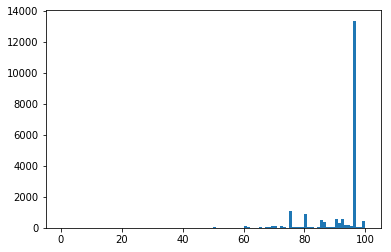

In [61]:
%matplotlib inline
_ = hist(imagenet_qualities, bins=100)

## Get different q-tables

In [24]:
man_q1 = np.ones((8, 8))
for i in range(8):
    for j in range(8):
        man_q1[i,j] = (i+j+1) * 14
man_q1
display_q_3d(man_q1)

In [26]:
rec_img, size = save_with_man_q(origin_image, man_q1)

In [20]:
f = BytesIO()
origin_image.save(f, format='JPEG', quality=10)
Image.open(f).quantization

{0: array('B', [80, 55, 60, 70, 60, 50, 80, 70, 65, 70, 90, 85, 80, 95, 120, 200, 130, 120, 110, 110, 120, 245, 175, 185, 145, 200, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255]),
 1: array('B', [85, 90, 90, 120, 105, 120, 235, 130, 130, 235, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255])}